1-2: Optimization

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torch.autograd import Variable
from sklearn.decomposition import PCA
import pandas as pd
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
import matplotlib
from matplotlib.pyplot import figure
torch.manual_seed(1)

In [3]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True) 
                                           
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())
print("train_dataset size:", len(train_dataset),"\ntest_dataset size:", len(test_dataset))

def train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size = batch_size, 
                                           shuffle=True)
    return train_loader


def test_loader(batch_size):
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
    return test_loader

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

train_dataset size: 60000 
test_dataset size: 10000


In [4]:
class DNN(nn.Module):
    def __init__(self,):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        # flatten as one dimension
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
def trainFunc(model,num_epochs,train_batch_size,status_interval):
    model.train()
    print('strated')
    train_load = train_loader(train_batch_size)
    n_total_steps = len(train_load)
    train_losses = []
    train_epoch = []
    train_acc = []
    epoch = 0
    modelParamWgt = pd.DataFrame()
    trainAvgLossArr = []
    trainAvgAccArr = []
    firstParaWgt = {}

    for epoch in range (num_epochs):
        epoch += 1
        n_correct = 0
        n_samples = 0
        lossSum =0
        totalacc=0
        epoch_df = pd.DataFrame()

        for i, (images, labels) in enumerate(train_load):  
            #if (i+1)% 60 == 0 : print(i+1)
            images, labels = Variable(images),Variable(labels)
            
            optimizer.zero_grad()
            
            # Forward pass
            prediction = model(images)

            images.requires_grad = True
            loss = loss_func(prediction, labels)
            lossSum += loss.detach().numpy()

            # Backward and optimize
            
            loss.backward()

            optimizer.step()

            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            acc = 100.0 * n_correct / n_samples
            totalacc += acc

            train_losses.append(loss.item())
            train_acc.append(acc)
            train_epoch.append(epoch)

            #Print Status
            if (i+1) % status_interval == 0:
                print (f'Train O/P: Epoch [{epoch}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}',end= '\r',flush = True)
        
        #Weight Collection
        for name, parameter in model.named_parameters():
            #print(name)
            if'weight' in name:
                weights = torch.nn.utils.parameters_to_vector(parameter).detach().numpy() 
                epoch_df = pd.concat([epoch_df, pd.DataFrame(weights).T], axis = 1) 

        modelParamWgt = pd.concat([modelParamWgt, epoch_df], axis = 0)     

       
        epochLoss = lossSum/n_total_steps
        epochAcc = totalacc/n_total_steps
        #print("Train Avg loss:",trainAvgLoss)
        trainAvgLossArr.append(epochLoss)    
        trainAvgAccArr.append(epochAcc)
                       
    return train_epoch,train_losses,train_acc,trainAvgLossArr,trainAvgAccArr, modelParamWgt

In [6]:
def testFunction(model,loss_func,test_batch_size): 
    test_load = test_loader(test_batch_size)
    model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        testLoss = 0
        count = 0
        for images, labels in test_load:
            images, labels = Variable(images),Variable(labels)
            
            prediction = model(images)
            testLoss += loss_func(prediction,labels).item()
            # max returns (value ,index)
            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            count += 1
    netTest_loss = testLoss/count
    netTest_acc1 = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test images: {netTest_acc1}% & Test Loss: {netTest_loss}',end= '\r',flush = True)
    return netTest_acc1, netTest_loss

In [7]:
def pcaOps(paramDF,itr):
    pcaOperation =  PCA(n_components=2)

    pcaVal = pcaOperation.fit_transform(paramDF)

    itrData = np.full((pcaVal.shape[0],1),itr)

    pcaDf = pd.DataFrame(np.append(pcaVal,itrData,axis=1),columns=['x','y','Itr No.'])

    return pcaDf

In [8]:
a=[]
tempModel = DNN()
for i in tempModel.parameters():
    a.append(torch.numel(i))
print(f'Total no of parameters:{np.sum(a)}')

Total no of parameters:418060


In [10]:
max_epochs = 45
all_df = pd.DataFrame()
columns=["x","y","Times"]
trainAllacc={}
testAllacc={}
trainAllloss={}
testAllloss={}
train_batch_size = 1000
test_batch_size = 1000
status_interval = 60
loss_func = nn.CrossEntropyLoss()
firstLayer = pd.DataFrame()

for count in range(8):

    j = copy.deepcopy(count)

    j = DNN()  

    print("Time: "+str(count))
    optimizer = torch.optim.Adam(j.parameters(),lr = 0.0004,weight_decay=1e-4)
    model_name1 = "Times:"+str(count)  
    
    train_epoch,train_losses,train_acc,trainAvgLoss,trainAvgAccArr, modelParamWgt = trainFunc(j,max_epochs,train_batch_size,status_interval)
    testAcc, testLoss = testFunction(j,loss_func,test_batch_size)

    all_df = all_df.append(modelParamWgt)
    
    testAllacc[count] = testAcc
    trainAllloss[count] = trainAvgLoss
    testAllloss[count] = testLoss
    trainAllacc[count] = trainAvgAccArr

Time: 0
strated
Time: 1
strated
Time: 2
strated
Time: 3
strated
Time: 4
strated
Time: 5
strated
Time: 6
strated
Time: 7
strated


In [11]:
trainAccArr = []
for key,values in enumerate(trainAllacc):
    trainAccArr.append(trainAllacc[key])
trainLossArr = []
for key,values in enumerate(trainAllloss):
    trainLossArr.append(trainAllloss[key])

print(all_df)
train_acc_df = pd.DataFrame(trainAccArr)
train_acc_data = np.array(train_acc_df).flatten()

train_loss_df = pd.DataFrame(trainLossArr)
train_loss_data = np.array(train_loss_df).flatten()

print(f'Shape of Loss:{np.shape(train_loss_data)} & Shape of Acc: {np.shape(train_acc_data)}')
t1 = all_df
print(pd.DataFrame(t1))


             0             1             2             3             4    \
0  -2.702642e-04 -6.833836e-05  9.451483e-03  1.664577e-03 -1.257509e-05   
0   3.955988e-05  4.875295e-06  1.215854e-03 -7.939936e-05 -2.828062e-08   
0  -1.951688e-07  7.664449e-07  2.074065e-05  2.395391e-06  3.837987e-08   
0  -5.964266e-08 -2.999389e-08 -2.116194e-06  5.498465e-08 -4.070786e-10   
0  -3.049072e-09  1.208915e-09  8.614253e-08 -6.410885e-09 -1.157997e-10   
..           ...           ...           ...           ...           ...   
0  -4.464940e-39  4.719506e-38  6.689799e-41  3.034282e-39 -1.057765e-38   
0  -4.464940e-39 -8.298492e-38  6.689799e-41  3.034282e-39 -1.057765e-38   
0  -4.464940e-39  4.741894e-38  6.689799e-41  3.034282e-39 -1.057765e-38   
0  -4.464940e-39  4.751366e-38  6.689799e-41  3.034282e-39 -1.057765e-38   
0  -4.464940e-39 -8.352054e-38  6.689799e-41  3.034282e-39 -1.057765e-38   

             5             6             7             8             9    ...  \
0  -2.

In [12]:
t1 = np.array(t1)
pca = PCA(n_components=2)
new_data = pca.fit_transform(t1)
# scaling=StandardScaler()
# scaled_data = scaling.fit_transform(new_data)

allEpochDf = pd.DataFrame(new_data,columns=['x','y'])

eps_each_time = [i for i in range(max_epochs)] * 8
times = np.repeat([i for i in range(8)],max_epochs)

allEpochDf['Epoch']=eps_each_time
allEpochDf['Iteration']=(times)
allEpochDf["Acc"] = train_acc_data
allEpochDf["Loss"] = train_loss_data

print(allEpochDf)
epoch3Df = allEpochDf.loc[(allEpochDf['Epoch']+1)%3 == 0]
epoch3Df = epoch3Df.reset_index(drop=True)
epoch3Df

            x         y  Epoch  Iteration        Acc      Loss
0    0.034569 -1.118688      0          0  55.754142  1.257588
1    0.052392 -1.378822      1          0  88.359983  0.391682
2    0.057727 -1.543150      2          0  91.693788  0.293345
3    0.065512 -1.683761      3          0  92.878323  0.249217
4    0.077578 -1.798481      4          0  93.864790  0.217012
..        ...       ...    ...        ...        ...       ...
355 -3.380524  5.450552     40          7  99.733638  0.017851
356 -3.372816  5.437819     41          7  99.757131  0.016937
357 -3.365703  5.427101     42          7  99.749803  0.016568
358 -3.356972  5.411720     43          7  99.766938  0.015666
359 -3.350400  5.395371     44          7  99.821089  0.014929

[360 rows x 6 columns]


,x,y,Epoch,Iteration,Acc,Loss
0,0.057727,-1.543150,2,0,91.693788,0.293345
1,0.085329,-1.900704,5,0,94.463370,0.192326
2,0.125524,-2.129528,8,0,95.860968,0.142754
3,0.166914,-2.291441,11,0,96.818877,0.110240
4,0.195779,-2.398232,14,0,97.555905,0.086601
...,...,...,...,...,...,...
115,-3.413284,5.513035,32,7,99.403393,0.027352
116,-3.409348,5.499432,35,7,99.588629,0.023444
117,-3.392471,5.471549,38,7,99.637851,0.020139
118,-3.372816,5.437819,41,7,99.757131,0.016937


In [13]:
test = np.array(epoch3Df.Acc)
mv = []
for i in range(len(test)):
    mv.append(str(int(test[i])))
len(mv)

120

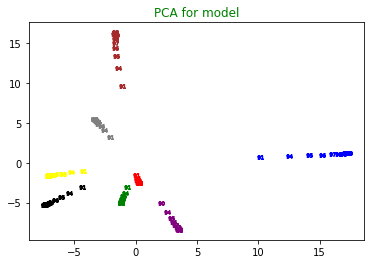

<Figure size 5000x2500 with 0 Axes>

In [14]:
cmap = ['red','blue','purple','green','yellow','brown','black','grey']

for i in range(len(mv)):
    m = mv[i]
    c = epoch3Df['Iteration'][i]
    plt.scatter(epoch3Df['x'][i],epoch3Df['y'][i],marker=f'${m}$',color = cmap[c])
    plt.title("PCA for model",color="g")
    
plt.figure(figsize=[10,5],dpi=500)


plt.show()

In [15]:
layer1_Df = all_df.iloc[:,0:7840]

t2 = layer1_Df 
t2 = np.array(t2)
pca = PCA(n_components=2)
new_data2 = pca.fit_transform(t2)

In [16]:
layer1Df = pd.DataFrame(new_data2,columns=['x','y'])

eps_each_time = [i for i in range(max_epochs)] * 8
times = np.repeat([i for i in range(8)],max_epochs)

layer1Df['Epoch']=eps_each_time
layer1Df['Iteration']=(times)
layer1Df["Acc"] = train_acc_data
layer1Df["Loss"] = train_loss_data

layer1Df


,x,y,Epoch,Iteration,Acc,Loss
0,0.221887,-0.454261,0,0,55.754142,1.257588
1,0.297105,-0.538884,1,0,88.359983,0.391682
2,0.346220,-0.576633,2,0,91.693788,0.293345
3,0.374999,-0.599630,3,0,92.878323,0.249217
4,0.395235,-0.611753,4,0,93.864790,0.217012
...,...,...,...,...,...,...
355,2.145390,0.298129,40,7,99.733638,0.017851
356,2.135120,0.301574,41,7,99.757131,0.016937
357,2.122413,0.301601,42,7,99.749803,0.016568
358,2.113111,0.297438,43,7,99.766938,0.015666


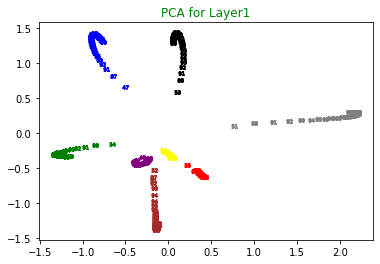

In [17]:
test = np.array(layer1Df.Acc)
mv = []
for i in range(len(test)):
    mv.append(str(int(test[i])))

for i in range(len(mv)):
    m = mv[i]
    c = layer1Df['Iteration'][i]
    plt.scatter(layer1Df['x'][i],layer1Df['y'][i],marker=f'${m}$',color = cmap[c])
    plt.title("PCA for Layer1",color="g")


plt.show()    